In [92]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [75]:
data = pd.read_csv('E://Data Science Docs//timeseries//AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


In [76]:
from datetime import datetime

con = data['Month']
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
 
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [77]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

# Stationary

In order to apply a time series model, it is important for the Time series to be stationary.
in other words all its statistical properties (mean,variance) remain constant over time. 
This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. 


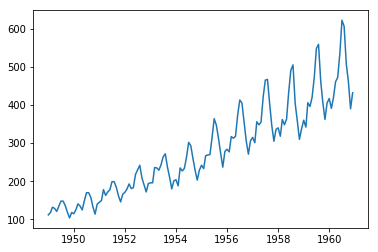

In [78]:
#In order to apply a time series model, it is important for the Time series to be stationary

plt.plot(ts)

It’s clear from the plot that there is an overall increase in the trend,with some seasonality in it.

In [79]:
# let's verify is the data is stationary or not using Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

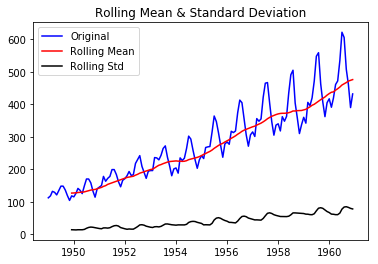

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [80]:
test_stationarity(ts)

here we can see that 'Test stat' > 'critical value', which should be less than critical value.

we need to remove Trend and Seasonality to make our data Stationary, 

# Trend

The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. 
These transformation can be log, sq-rt, cube root etc . 
Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

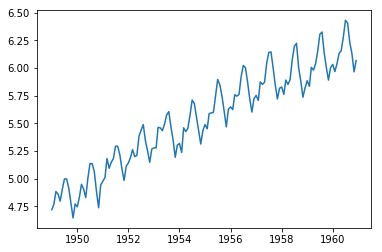

In [81]:
ts_log = np.log(ts)
plt.plot(ts_log)

to reduce trend from your data we generally use :
    
    Smoothing: using rolling/moving average
    Aggression: by taking the mean for a certain time period (year/month)
        
Here we are using SMOOTHING

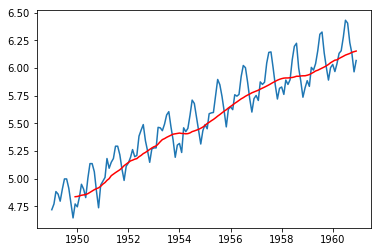

In [82]:
moving_avg = ts_log.rolling(12).mean() # rolling mean for the transformed data

plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

In [83]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

In [84]:
ts_log_moving_avg_diff = ts_log_moving_avg_diff.dropna()
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

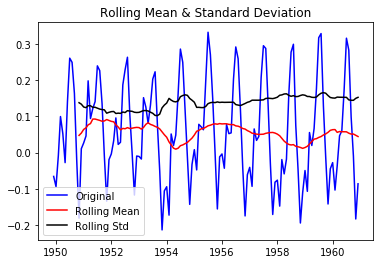

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [85]:
test_stationarity(ts_log_moving_avg_diff)

The rolling values are varying slightly but there is no specific trend.
The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

EWMA:
    
The exponentially weighted moving average (EWMA) improves on simple variance by assigning weights to the periodic returns. 
By doing this, we can both use a large sample size but also give greater weight to more recent returns

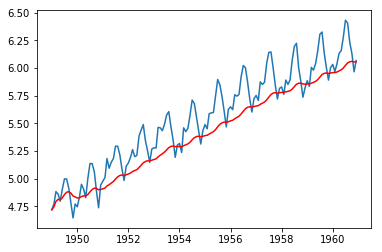

In [86]:
expweighted_avg = ts_log.ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

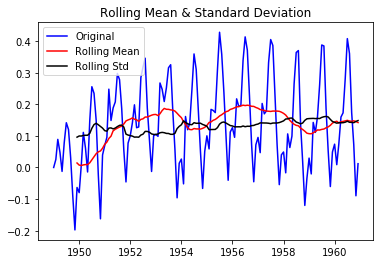

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [87]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

# Seasonality (along with Trend)

There are two common methods to remove trend and seasonality, they are:

    Differencing: by taking difference using time lag
    Decomposition: model both trend and seasonality, then remove them


# Differencing

Here we first take the difference of the value at a particular time with that of the previous time. Now let’s do it in Pandas.

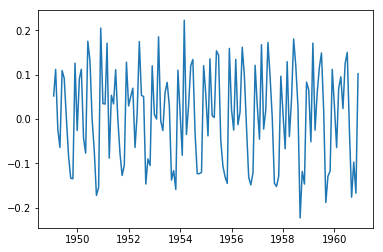

In [89]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

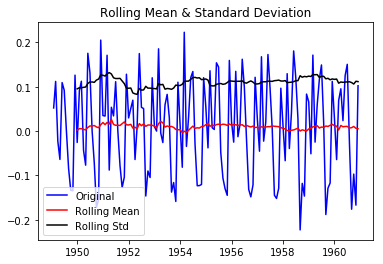

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [90]:
ts_log_diff = ts_log_diff.dropna()
test_stationarity(ts_log_diff)

from the graph and the statistics results we can say the mean and std variations have small variations with time.
test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

# Decomposing

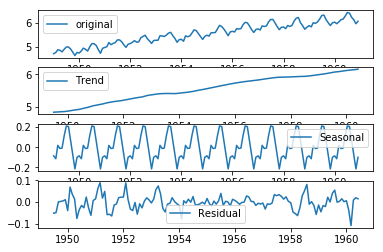

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

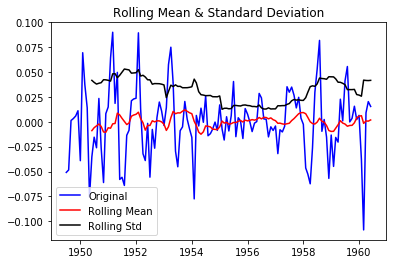

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [59]:
ts_log_decompose = residual

ts_log_decompose = ts_log_decompose.dropna()

test_stationarity(ts_log_decompose)

we can see from the above data that This is stationary because:
    
    test statistic is lower than 1% critical values.
    the mean and std variations have small variations with time.

# ARIMA

Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .

Now let’s check out on how we can figure out what value of p and q to use. We use two popular plotting techniques:
    
    Autocorrelation Function (ACF)
    Partial Autocorrelation Function (PACF)

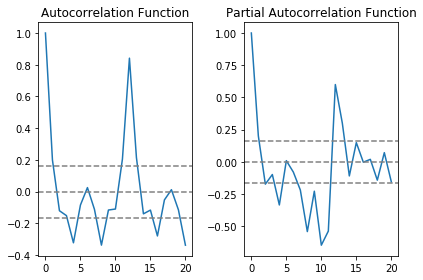

In [64]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#plot acf & pacf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

From the above we got below mentioned below:
        
    p: The first time where the PACF crosses the upper confidence interval, here its close to 2. hence p = 2.
    q: The first time where the ACF crosses the upper confidence interval, here its close to 2. hence p = 2.

# AR model

Text(0.5, 1.0, 'RSS: 1.5023')

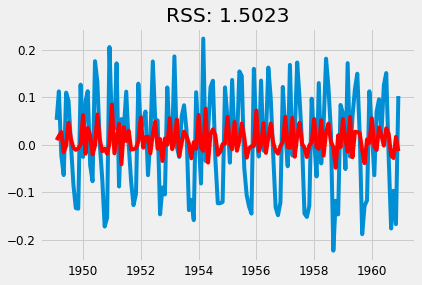

In [107]:
model = ARIMA(ts_log, order=(2, 1, 0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

# MA Model

Text(0.5, 1.0, 'RSS: 1.4721')

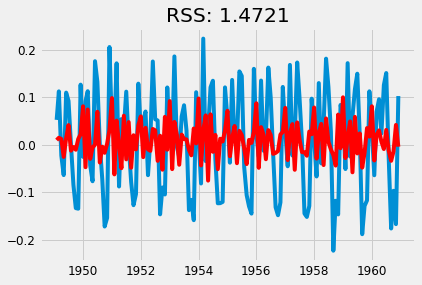

In [106]:
model = ARIMA(ts_log, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 1.0292')

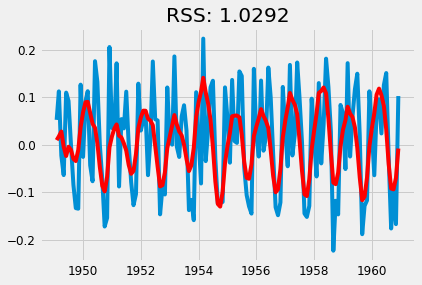

In [105]:
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [111]:
predict_arima_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predict_arima_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [112]:
predict_arima_diff_cumsum = predict_arima_diff.cumsum()
print(predict_arima_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [115]:
predict_arima_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predict_arima_log = predict_arima_log.add(predict_arima_diff_cumsum, fill_value=0)
print(predict_arima_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64


Text(0.5, 1.0, 'RMSE: 90.1045')

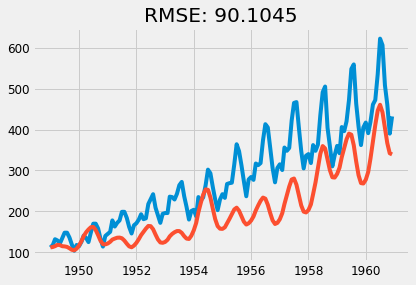

In [116]:
predict_ARIMA = np.exp(predict_arima_log)

plt.plot(ts)
plt.plot(predict_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_ARIMA-ts)**2)/len(ts)))